# ID R&D antispoofing challenge

### Necessary libraries

In [0]:
import os
import torch
import torchvision
import numpy as np
import copy
# import torchsummary

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import colors, pyplot as plt
from time import gmtime, strftime
from torchvision.models import vgg16_bn
from tqdm import tqdm, tqdm_notebook
from operator import itemgetter

In [2]:
# If you want deterministic, just uncomment the lines below.

'''
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
'''

'\nnp.random.seed(0)\ntorch.manual_seed(0)\ntorch.cuda.manual_seed(0)\ntorch.backends.cudnn.deterministic = True\n'

### Global variables

In [3]:
IMAGE_TYPE = ['2dmask', 'real', 'printed', 'replay']
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
RESCALE_SIZE = 224
WORK_DIR = ''
PATH_DATA = WORK_DIR + '/train_sample'

print('You are working on ' + str(DEVICE))

You are working on cuda:0


In [4]:
# If you are using google colab, uncomment the lines below.

from google.colab import drive
drive.mount('/content/drive/')

WORK_DIR = '/content/drive/My Drive/Colab Notebooks/Projects/antispoofing'
PATH_DATA = WORK_DIR + '/train_sample'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Upload data

In [0]:
class AntispoofDataset(Dataset):
    
    def __init__(self, path_videos, loader = torchvision.datasets.folder.default_loader,
                 transform = None):
        super().__init__()

        self.path_videos = path_videos
        self.transform = transform
        self.loader = loader
    
    def __getitem__(self, index):
        video_info = self.path_videos[index]
        frames = os.listdir(video_info['path'])
        images = []

        for frame in frames:
            images.append(self.loader(os.path.join(video_info['path'], frame)))

            if self.transform is not None:
                images[-1] = self.transform(images[-1])

        return (torch.Tensor([np.array(image) for image in images]), video_info['label'])

    def __len__(self):
        return len(self.path_videos)

In [0]:
# Upload video paths

path_videos = []

for label in IMAGE_TYPE:
    videos = os.listdir(os.path.join(PATH_DATA, label))

    for video in videos:
        if not os.path.isdir(os.path.join(PATH_DATA, label, video)):
            continue

        path_videos.append({
                'path': os.path.join(PATH_DATA, label, video),
                'label': int(label != 'real'),
        })

X_train, X_test = train_test_split(path_videos, test_size = 0.2, random_state = 123)

In [0]:
data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.Resize(RESCALE_SIZE),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(MEAN, STD)]),
    'val': torchvision.transforms.Compose([
        torchvision.transforms.Resize(RESCALE_SIZE),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(MEAN, STD)])
}

image_datasets = {
    'train': AntispoofDataset(
        X_train, transform = data_transforms['train']),
    'val': AntispoofDataset(
        X_test, transform = data_transforms['val'])}

data_loaders = {
  x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size = 10, shuffle = True, num_workers = 4)
    for x in ['train', 'val']}

Let's see our data

In [0]:
def imshow(tensor_image, ploter = plt, title = None):
    image = tensor_image.numpy().transpose((1, 2, 0))
    image = np.array(STD) * image + np.array(MEAN)
    image = np.clip(image, 0, 1)

    ploter.imshow(image)

    if title is not None:
        ploter.set_title(title)
    ploter.grid(False)

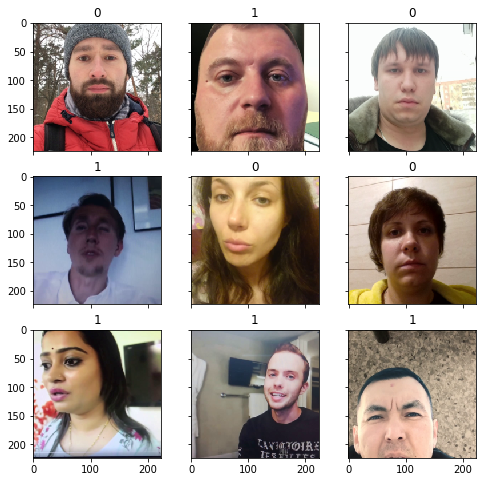

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey = True, sharex = True)

for fig_x in ax.flatten():
    random_character = int(np.random.uniform(0, 1000))
    images, label = image_datasets['train'][random_character]
    
    imshow(images[0].data.cpu(), title = label, ploter = fig_x)

### Neural networks

Common functions

In [0]:
def save_weights(model, model_name, val_acc):
    name = strftime("%Yy.%mm.%dd.%Hh.%Mm", gmtime())
    model_weights = copy.deepcopy(model.state_dict())
    torch.save(model_weights, \
               f"{WORK_DIR}/weights/{model_name}/{round(val_acc, 3)}___{name}.pth") 

In [0]:
def load_weights(model, model_name, weights_name):
    model.load_state_dict(torch.load(f"{WORK_DIR}/weights/{model_name}/{weights_name}"))
    model.eval()

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

GRADIANT

[FACE ANTI-SPOOFING BASED ON COLOR TEXTURE ANALYSIS](https://arxiv.org/abs/1511.06316)

In [0]:
from skimage import feature, color

images, label = image_datasets['train'][1000]
hsv_image = color.rgb2hsv(images[0].permute(2, 1, 0).permute(1, 0, -1))
ycbcr_image = color.rgb2ycbcr(images[0].permute(2, 1, 0).permute(1, 0, -1))

lbp_hsv_0 = feature.local_binary_pattern(hsv_image[:, :, 0], P = 8, R = 1, method='uniform')
lbp_hsv_1 = feature.local_binary_pattern(hsv_image[:, :, 1], P = 8, R = 1, method='uniform')
lbp_hsv_2 = feature.local_binary_pattern(hsv_image[:, :, 2], P = 8, R = 1, method='uniform')

lbp_ycbcr_0 = feature.local_binary_pattern(ycbcr_image[:, :, 0], P = 8, R = 1, method='uniform')
lbp_ycbcr_1 = feature.local_binary_pattern(ycbcr_image[:, :, 1], P = 8, R = 1, method='uniform')
lbp_ycbcr_2 = feature.local_binary_pattern(ycbcr_image[:, :, 2], P = 8, R = 1, method='uniform')

features = np.concatenate((lbp_hsv_0.ravel(), lbp_hsv_1.ravel(), lbp_hsv_2.ravel(),
                          lbp_ycbcr_0.ravel(), lbp_ycbcr_1.ravel(), lbp_ycbcr_2.ravel()), axis = 0)

In [0]:
# from sklearn.feature_selection import RFE
# from sklearn.svm import SVC


# >>> estimator = SVR(kernel="linear")
# >>> selector = RFE(estimator, 5, step=1)
# >>> selector = selector.fit(X, y)
# >>> selector.support_
# array([ True,  True,  True,  True,  True, False, False, False, False,
#        False])

# estimator = SVC()

# def train_svm(data_loader, estimator):
#     history = []
#     log_template = "\nLog epoch {ep:03d}:\n\ttrain_loss: {t_loss:0.4f} \n\tval_loss {v_loss:0.4f} \n\ttrain_acc {t_acc:0.4f} \n\tval_acc {v_acc:0.4f}"

#     with tqdm(desc="epoch", total = epochs) as pbar_outer:
#         for epoch in range(3):
            

SZCVI

The video frames were resized into 224×224 images and fed into a CNN model. The architecture of this model consists of five convolutional layers and one fully connected layer. The convolutional layers were inspired by the VGG model. The scores of the sampled frames were averaged to obtain the final score for each video file.

In [0]:
class SZCVI(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.module = torch.nn.Sequential(
            *(list(vgg16_bn(pretrained=True).features[:17])),
            Flatten(),
            torch.nn.Linear(256 * 56 * 56, 2)
        )

    def forward(self, x):
        return self.module(x)

In [0]:
model = SZCVI().to(DEVICE)

# load_weights(model, 'My', weights_name='0.9___2020y.02m.09d.10h.42m.pth')

### Train

In [0]:
def fit_epoch(model, data_loader, loss_fn, optimizer):
    model.train(True)

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for batch, labels in data_loader:
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        predictions = []
        for i in range(5):
            predictions.append([model(batch[:, i])])
        
        
        predictions = sum(model(batch[:, i].to(DEVICE)) for i in range(5)) / 5
        loss = loss_fn(predictions, labels)

        loss.backward()
        optimizer.step()

        predictions = torch.argmax(predictions, 1)
        running_loss += loss.item() * batch.size(0)
        running_corrects += torch.sum(predictions == labels.data)
        processed_data += batch.size(0)
        
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [0]:
def eval_epoch(model, data_loader, loss_fn):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for batch, labels in data_loader:
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)
        

        with torch.set_grad_enabled(False):
            predictions = sum(model(batch[:, i].to(DEVICE)) for i in range(5)) / 5
            loss = loss_fn(predictions, labels)
            predictions = torch.argmax(predictions, 1)

        running_loss += loss.item() * batch.size(0)
        running_corrects += torch.sum(predictions == labels.data)
        processed_size += batch.size(0)

    loss = running_loss / processed_size
    acc = running_corrects.double() / processed_size

    return loss, acc

In [0]:
def train(data_loader, model, epochs, model_name, save = False):
    history = []
    log_template = "\nLog epoch {ep:03d}:\n\ttrain_loss: {t_loss:0.4f} \n\tval_loss {v_loss:0.4f} \n\ttrain_acc {t_acc:0.4f} \n\tval_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total = epochs) as pbar_outer:
        optimizer = torch.optim.Adam(model.parameters())
        loss_fn = torch.nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, data_loader['train'], 
                                              loss_fn, optimizer)
            val_loss, val_acc = eval_epoch(model, data_loader['val'], loss_fn)

            history.append((train_loss, train_acc, val_loss, val_acc))
            tqdm.write(log_template.format(ep = epoch + 1, t_loss = train_loss, 
                                           v_loss = val_loss, t_acc = train_acc, 
                                           v_acc = val_acc))
            pbar_outer.update(1)

            if save:
                save_weights(model, model_name, val_acc.item())
            
    return history

In [0]:
def show_history(history):
    loss, acc, val_loss, val_acc = zip(*history)

    plt.figure(figsize = (15, 9))
    plt.plot(acc, label = "train_acc")
    plt.plot(val_acc, label = "val_acc")
    plt.legend(loc = 'best')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.show()

In [21]:
history = train(data_loaders, model = model, epochs = 3, model_name='My', save = True)

epoch:  33%|███▎      | 1/3 [22:43<45:27, 1363.51s/it]


Log epoch 001:
	train_loss: 2.5686 
	val_loss 0.6311 
	train_acc 0.7746 
	val_acc 0.8073


epoch:  67%|██████▋   | 2/3 [44:50<22:32, 1352.59s/it]


Log epoch 002:
	train_loss: 0.6693 
	val_loss 0.8654 
	train_acc 0.8355 
	val_acc 0.7279


epoch: 100%|██████████| 3/3 [1:06:19<00:00, 1333.35s/it]


Log epoch 003:
	train_loss: 0.3279 
	val_loss 0.3943 
	train_acc 0.8899 
	val_acc 0.8503
